This notebook was written and used on a local machine and doesn't require CUDA or CUDNN.
This notebook computes the custom anchors of our dataset to be used for YOLO training.

## Variables to be modified accordingly 

In [ ]:
# Path to the .txt file containing the class names
Class_file = 'Yolo_builds/Colour_Helmet_detection/class_names.txt'

# Path to the folder containing the bounding box annotations
annotation_dir = 'Yolo_builds/Colour_Helmet_detection/Data_set/Images_and_annotations'

# No of anchors to be calculated
No_of_Centroids = 9 #No of K-mean centroids

## Installations and Importations

In [1]:
import cv2 as cv 
import numpy as np
from matplotlib import pyplot as plt
import os
%matplotlib notebook

## Get the annotated text folder 

In [2]:
# Get all classes present in corresponding annotation
with open(Class_file) as f:
    Classes = f.readlines()
for i in range(len(Classes)-1):
    Classes[i] = Classes[i][:-1]

# Get all Boxes present in all of the annotation files in class-wise manner
Boxes_classwise = [[] for i in range(len(Classes))]
for file in os.listdir(annotation_dir):
    if file.endswith('.txt'):
        with open(annotation_dir + '/' + file) as f:
            while True:
                annotation = f.readline()
                if(annotation == ''):
                    break
                box = [float(value) for value in annotation.split()]
                Boxes_classwise[int(box[0])].append([box[3], box[4]])

Boxes_classwise = [np.array(Boxes_classwise[i]) for i in range(len(Classes))]

## Scattering

<IPython.core.display.Javascript object>


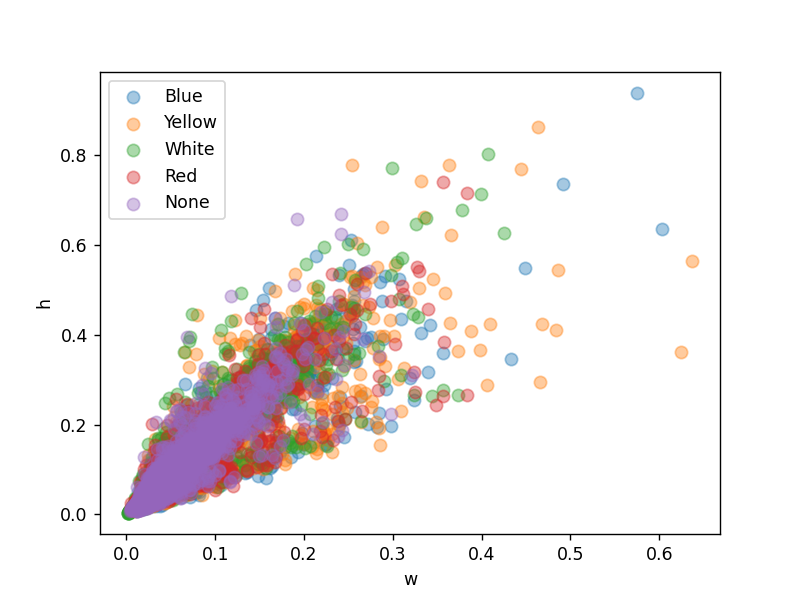

<IPython.core.display.Javascript object>


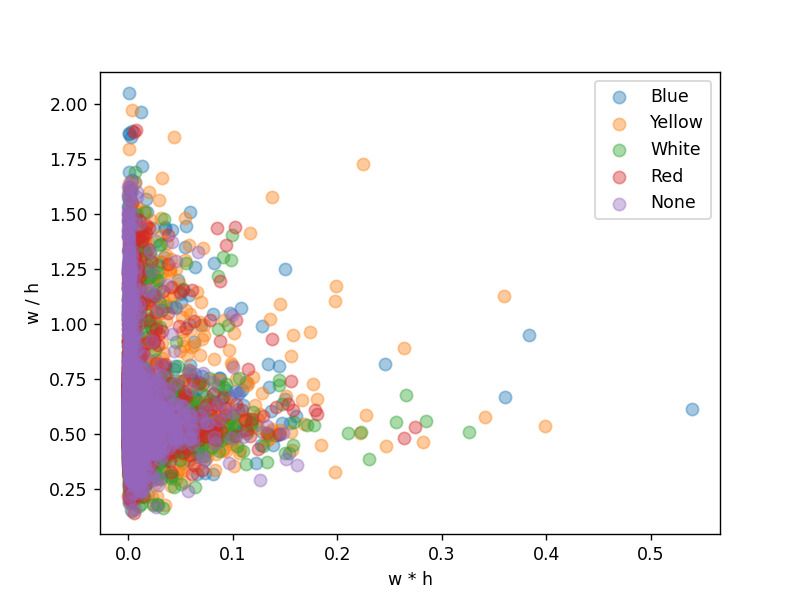

Text(0, 0.5, 'w / h')

In [3]:
plt.figure(1)
for class_no in range(len(Classes)):
    plt.scatter(Boxes_classwise[class_no][:,0], Boxes_classwise[class_no][:,1], s=50, alpha=0.4, label = Classes[class_no])#, facecolors='none', edgecolors=np.random.uniform(0, 1, size=(1,3)))
plt.legend()
plt.xlabel('w')
plt.ylabel('h')

plt.figure(2)
for class_no in range(len(Classes)):
    plt.scatter(np.multiply(Boxes_classwise[class_no][:,0],Boxes_classwise[class_no][:,1]), np.divide(Boxes_classwise[class_no][:,0],Boxes_classwise[class_no][:,1]), s=50, alpha=0.4, label = Classes[class_no])#, facecolors='none', edgecolors=np.random.uniform(0, 1, size=(1,3)))
plt.legend()
plt.xlabel('w * h')
plt.ylabel('w / h')

In [4]:
#Get all class boxes in a single list
Boxes = Boxes_classwise[0]
for i in range(1, len(Classes)):
    Boxes = np.append(Boxes, Boxes_classwise[i], axis=0)

## IOU func 

In [5]:
def IOU(w1, h1, w2, h2):
    I = min(w1,w2)*min(h1,h2)
    U = w1*w2 + h1*h2 - I
    return (I/U)

# Kmeans 

In [19]:
Iterations = 25 #No of K-means iterations
GD_Iterations = 40 #No of GD iterations per K-means iteration
delta = 0.00002 #Arbitarily small number
GD_step = 0.0008 #Gradient step per GD iteration

# INITIALIZATION
Centroids = np.random.uniform(0, 0.3, size=(No_of_Centroids,2)) #This line needs to be changed depending on the scatter plot observed above
#Centroids = np.array([[5, 8],  [10, 18],  [15, 28],  [21, 39],  [29, 51],  [38, 72],  [56, 90],  [71,132], [113,180]])/416
#print(Centroids)

for iteration in range(Iterations):
    print('Current K-means iteration:', iteration, ', ', end='')

    # CLUSTERING
    IOU_matrix = np.zeros((No_of_Centroids, Boxes.shape[0]))
    for cluster_no in range(No_of_Centroids):
        for exp_no in range(Boxes.shape[0]):
            IOU_matrix[cluster_no, exp_no] = IOU(Centroids[cluster_no,0], Centroids[cluster_no,1], Boxes[exp_no,0], Boxes[exp_no,1])
    Clusters = np.argmax(IOU_matrix, axis=0)
    
    # Print current IOU loss
    Loss = 1 - np.sum(np.max(IOU_matrix, axis=0))/Boxes.shape[0]
    print('Loss:', Loss, '|', end='')
    
    # Over each cluster
    for cluster_no in range(No_of_Centroids):
        Cluster_boxes = Boxes[Clusters == cluster_no]
        print( Cluster_boxes.shape[0], '|', end='')
        
        # DO GD
        for GD_iteration in range(GD_Iterations):
            if(Cluster_boxes.shape[0] == 0):
                break
            # Computer gradients
            d_Centroid = np.zeros(2)
            for exp_no in range(Cluster_boxes.shape[0]):
                d_Centroid[0] = d_Centroid[0] + (IOU(Centroids[cluster_no,0] + delta, Centroids[cluster_no,1], Cluster_boxes[exp_no,0], Cluster_boxes[exp_no,1]) - IOU(Centroids[cluster_no,0], Centroids[cluster_no,1], Cluster_boxes[exp_no,0], Cluster_boxes[exp_no,1]))/delta
                d_Centroid[1] = d_Centroid[1] + (IOU(Centroids[cluster_no,0], Centroids[cluster_no,1] + delta, Cluster_boxes[exp_no,0], Cluster_boxes[exp_no,1]) - IOU(Centroids[cluster_no,0], Centroids[cluster_no,1], Cluster_boxes[exp_no,0], Cluster_boxes[exp_no,1]))/delta
            
            # Update
            Centroids[cluster_no] = Centroids[cluster_no] + (d_Centroid/np.linalg.norm(d_Centroid)) * GD_step * np.sqrt((Iterations - iteration)/Iterations)
    print('\n')

print('Finished.\n')

Current K-means iteration: 0 , Loss: 0.5619643316165184 |33 |4 |32 |1629 |8166 |58 |714 |929 |7328 |

Current K-means iteration: 1 , Loss: 0.5061746445396783 |51 |6 |96 |2042 |6897 |869 |489 |1134 |7309 |

Current K-means iteration: 2 , Loss: 0.4475624506379803 |85 |10 |127 |2320 |6909 |1995 |516 |1041 |5890 |

Current K-means iteration: 3 , Loss: 0.41075871856596546 |111 |16 |160 |2813 |6365 |2478 |515 |1067 |5368 |

Current K-means iteration: 4 , Loss: 0.404577999974542 |129 |41 |200 |3065 |5887 |2750 |567 |1156 |5098 |

Current K-means iteration: 5 , Loss: 0.4011999691911565 |175 |64 |243 |3181 |5520 |2874 |581 |1290 |4965 |

Current K-means iteration: 6 , Loss: 0.3989187237755797 |240 |90 |267 |3232 |5262 |2939 |624 |1375 |4864 |

Current K-means iteration: 7 , Loss: 0.3970226058250321 |374 |111 |289 |3343 |5056 |2979 |647 |1363 |4731 |

Current K-means iteration: 8 , Loss: 0.39584151003088675 |492 |133 |297 |3400 |4929 |3002 |674 |1354 |4612 |

Current K-means iteration: 9 , Loss:

## Cluster plots and result

<IPython.core.display.Javascript object>


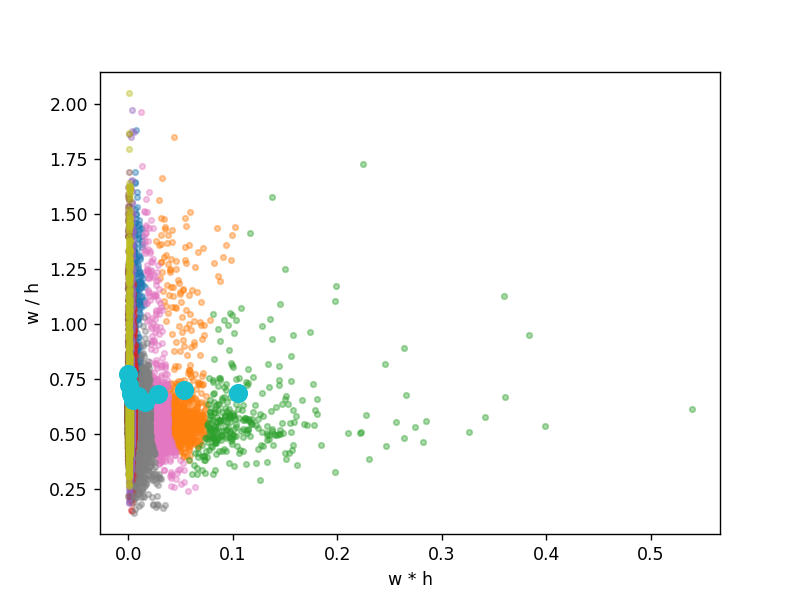

[[ 32.44943553  48.26932698]
 [ 80.23755543 114.66829718]
 [111.98565475 162.62842547]
 [ 23.53098051  35.74545827]
 [ 16.70275236  24.39729904]
 [  5.80295675   7.49740215]
 [ 57.85328415  84.3992877 ]
 [ 42.30172453  65.57696201]
 [ 10.90009296  15.04659445]]


In [20]:
# One last CLUSTERING
IOU_matrix = np.zeros((No_of_Centroids, Boxes.shape[0]))
for cluster_no in range(No_of_Centroids):
    for exp_no in range(Boxes.shape[0]):
        IOU_matrix[cluster_no, exp_no] = IOU(Centroids[cluster_no,0], Centroids[cluster_no,1], Boxes[exp_no,0], Boxes[exp_no,1])
Clusters = np.argmax(IOU_matrix, axis=0)
    
plt.figure()
for cluster_no in range(No_of_Centroids):
    Cluster_boxes = Boxes[Clusters == cluster_no]
    plt.scatter(np.multiply(Cluster_boxes[:,0],Cluster_boxes[:,1]), np.divide(Cluster_boxes[:,0],Cluster_boxes[:,1]), s=10, alpha=0.4)#, facecolors='none', edgecolors=np.random.uniform(0, 1, size=(1,3)))
plt.scatter(np.multiply(Centroids[:,0],Centroids[:,1]), np.divide(Centroids[:,0],Centroids[:,1]), s=100)
plt.xlabel('w * h')
plt.ylabel('w / h')

print(Centroids*416)